### Correlation between the IFS-AMIP twin experiments with and without eddies in the SST forcing
- Analysed here is the DJF correlation between the twin experiments with and w/o eddy forcing in the SSTs in terms of differences in the variability of the following variables:
    - mean surface latent heat flux
    - 10m zonal wind
    - mean sea level pressure
    - 2m air temperature
    - sea surface temperature
- The correlation for DJF values is calculated, thus we do not need to remove the seasonal cycle. If the correlation to be calculated over all season then removing seasonal cycle is recommended.

- Correlation and significance test is calculated with the xskillscore package: https://xskillscore.readthedocs.io/en/stable/quick-start.html#Correlation-Based, which is really fast and handy.

Iuliia Polkova polkova@dkrz.de

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import intake
from dask.diagnostics import ProgressBar

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import hvplot.xarray
import xskillscore as xs

In [2]:
def ifs_to_latlon(ds):
    '''
    Uses the latitude-longitude information encoded in the regular grid IFS output to reconstructed the regular grid
    '''
    return ds.rename({'value':'latlon'}).set_index(latlon=("lat","lon")).unstack("latlon")
def ifs_fix_time_for_monthly_data(ds):
    '''
    Monthly mean data has the time axis encoded incorrectly.
    This function shifts it back by one day
    '''
    return ds.assign_coords(time=ds['time']- pd.Timedelta('1D'))


## Open and inspect the catalogue

In [3]:
cat = intake.open_catalog('https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/eerie.yaml')\
                          ['dkrz']['disk']['model-output']['ifs-amip']

In [4]:
list(cat)

['amip-hist-obs.atmos.gr025',
 'amip-hist-obs-lr30.atmos.gr025',
 'amip-ng-obs.atmos.gr025',
 'amip-ng-obs-lr30.atmos.gr025']

In [5]:
list(cat['amip-hist-obs.atmos.gr025'])

['2D_const_0.25deg',
 '2D_6h_0.25deg',
 '2D_24h_0.25deg',
 '2D_monthly_0.25deg',
 '3D_6h_0.25deg',
 '3D_24h_0.25deg',
 '3D_monthly_0.25deg']

## Load the data to dask (lazy!)

In [6]:
ds_smooth = cat['amip-hist-obs-lr30.atmos.gr025']['2D_monthly_0.25deg'].to_dask()
ds = cat['amip-hist-obs.atmos.gr025']['2D_monthly_0.25deg'].to_dask()
# The following is necessary for MONTHLY data, NOT step data!
ds_smooth = ifs_fix_time_for_monthly_data(ds_smooth)
ds = ifs_fix_time_for_monthly_data(ds)

In [7]:
ds_smooth = ifs_to_latlon(ds_smooth)
ds = ifs_to_latlon(ds)

In [8]:
ds

<xarray.Dataset>
Dimensions:  (lat: 721, lon: 1440, time: 132)
Coordinates:
  * lat      (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * time     (time) datetime64[ns] 2010-01-31 2010-02-28 ... 2020-12-31
Data variables: (12/50)
    10si     (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    10u      (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    10v      (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    2d       (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    2t       (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    cape     (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    ...       ...
    swvl4    (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    tcc      (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    tciw     (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    tclw     (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    tcwv     (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    tprate   (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
Attributes:
    edition:            1
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          0
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...

### Correlation (with p-value) between two twin experiments for DJF show where they differ in terms of the variability

In [9]:
def month_selector(month):
    return (month >= 1) & (month <= 2) | (month >=12) # select Jan, Feb, Dec

def djf_average(x_djf):
    x_djf = x_djf.rolling(time = 3).mean() # rolling mean over three months: JFD, FDJ, DJF, ...
    x_djf = x_djf[x_djf.time.dt.month == 12] # pick rolling mean that starts with Dec
    return x_djf


In [10]:
# Mean surface latent heat flux 
lhf_djf = ds["mslhfl"].sel(time=month_selector(ds["mslhfl"]['time.month']))
lhf_djf = djf_average(lhf_djf)

lhf_smooth_djf = ds_smooth["mslhfl"].sel(time=month_selector(ds_smooth["mslhfl"]['time.month']))
lhf_smooth_djf = djf_average(lhf_smooth_djf)

# 10 metre U wind component
u10_djf = ds["10u"].sel(time=month_selector(ds["10u"]['time.month']))
u10_djf = djf_average(u10_djf)

u10_smooth_djf = ds_smooth["10u"].sel(time=month_selector(ds_smooth["10u"]['time.month']))
u10_smooth_djf = djf_average(u10_smooth_djf)

# Mean sea level pressure
msl_djf = ds["msl"].sel(time=month_selector(ds["msl"]['time.month']))
msl_djf = djf_average(msl_djf)

msl_smooth_djf = ds_smooth["msl"].sel(time=month_selector(ds_smooth["msl"]['time.month']))
msl_smooth_djf = djf_average(msl_smooth_djf)

# sea surface temperature
sst_djf = ds["sst"].sel(time=month_selector(ds["sst"]['time.month']))
sst_djf = djf_average(sst_djf)

sst_smooth_djf = ds_smooth["sst"].sel(time=month_selector(ds_smooth["sst"]['time.month']))
sst_smooth_djf = djf_average(sst_smooth_djf)

# 2m temperature
t2m_djf = ds["2t"].sel(time=month_selector(ds["2t"]['time.month']))
t2m_djf = djf_average(t2m_djf)

t2m_smooth_djf = ds_smooth["2t"].sel(time=month_selector(ds_smooth["2t"]['time.month']))
t2m_smooth_djf = djf_average(t2m_smooth_djf)


In [11]:
#t2m_corr = xr.corr(t2m_djf, t2m_smooth_djf, dim="time")
# Mean surface latent heat flux 
lhf_r = xs.pearson_r(lhf_djf.chunk({"time": -1}), lhf_smooth_djf.chunk({"time": -1}), dim='time', skipna=True).compute()
pp = xs.pearson_r_p_value(lhf_djf.chunk({"time": -1}), lhf_smooth_djf.chunk({"time": -1}), dim='time', skipna=True).compute()
lhf_r_mask=lhf_r.where(pp < 0.05)

# 10 metre U wind component
u10_r = xs.pearson_r(u10_djf.chunk({"time": -1}), u10_smooth_djf.chunk({"time": -1}), dim='time', skipna=True).compute()
pp = xs.pearson_r_p_value(u10_djf.chunk({"time": -1}), u10_smooth_djf.chunk({"time": -1}), dim='time', skipna=True).compute()
u10_r_mask=u10_r.where(pp < 0.05)

# Mean sea level pressure
msl_r = xs.pearson_r(msl_djf.chunk({"time": -1}), msl_smooth_djf.chunk({"time": -1}), dim='time', skipna=True).compute()
pp = xs.pearson_r_p_value(msl_djf.chunk({"time": -1}), msl_smooth_djf.chunk({"time": -1}), dim='time', skipna=True).compute()
msl_r_mask=msl_r.where(pp < 0.05)

# sea surface temperature
sst_r = xs.pearson_r(sst_djf.chunk({"time": -1}), sst_smooth_djf.chunk({"time": -1}), dim='time', skipna=True).compute()
pp = xs.pearson_r_p_value(sst_djf.chunk({"time": -1}), sst_smooth_djf.chunk({"time": -1}), dim='time', skipna=True).compute()
sst_r_mask=sst_r.where(pp < 0.05)

# 2m temperature
t2m_r = xs.pearson_r(t2m_djf.chunk({"time": -1}), t2m_smooth_djf.chunk({"time": -1}), dim='time', skipna=True).compute()
pp = xs.pearson_r_p_value(t2m_djf.chunk({"time": -1}), t2m_smooth_djf.chunk({"time": -1}), dim='time', skipna=True).compute()
t2m_r_mask=t2m_r.where(pp < 0.05)


/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:351: RuntimeWarning: divide by zero encountered in divide
  t_squared = r ** 2 * (dof / ((1.0 - r) * (1.0 + r)))


### Plot correlation 

/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1714: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


Text(0.5, 1.0, 't2m DJF correlation')

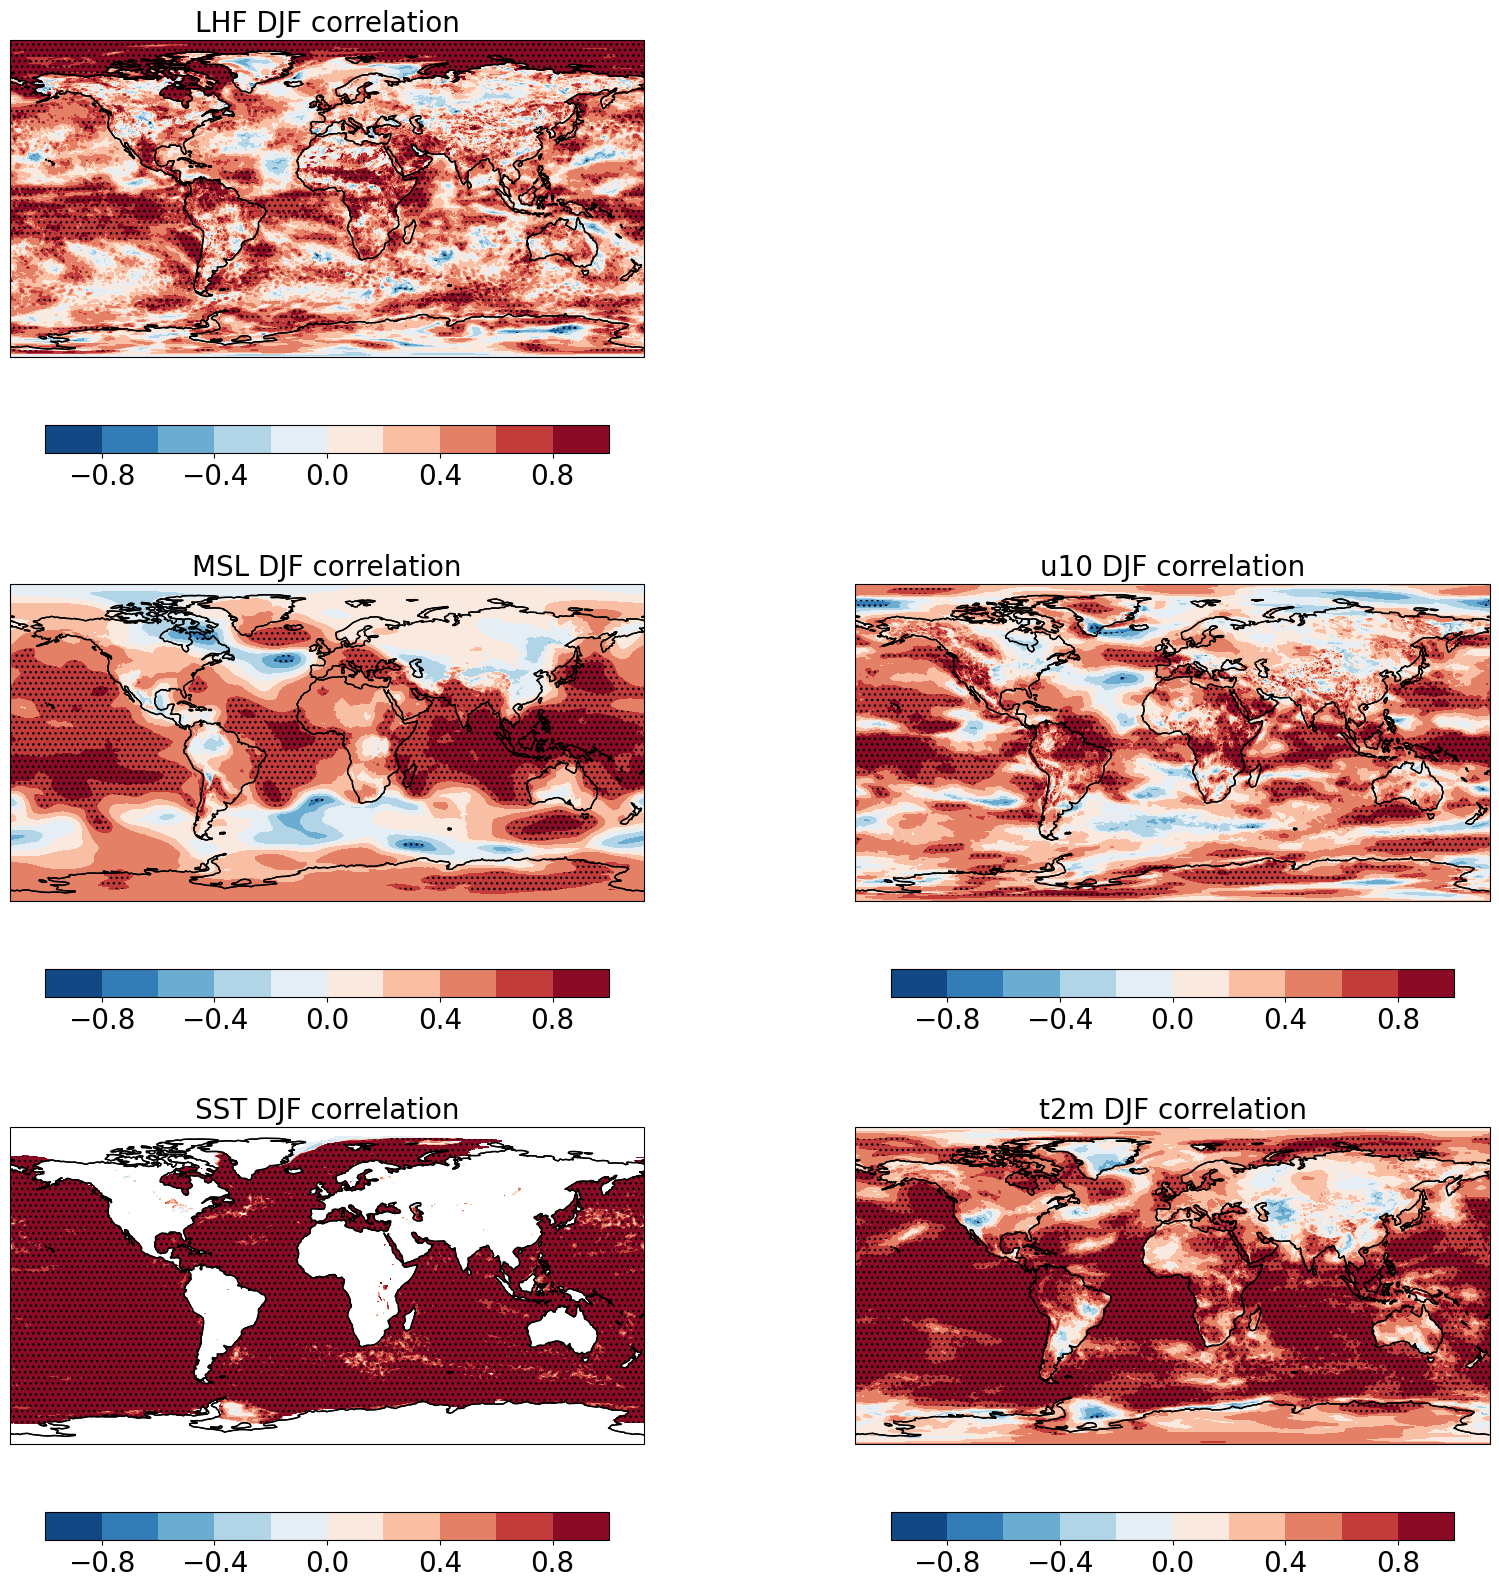

In [12]:
fig=plt.figure(figsize=(20,20))
proj=ccrs.PlateCarree()

levels = np.linspace(-1, 1, 11)

ax1 = plt.subplot(321, projection=proj)
ax1.coastlines(resolution='110m')
p = ax1.contourf(ds.lon, ds.lat, lhf_r,
                 vmin=-1,vmax=1,levels=levels,
               #extend='max',
               cmap = plt.get_cmap('RdBu_r'),
               transform=ccrs.PlateCarree())
pp=ax1.contourf(ds.lon, ds.lat, lhf_r_mask, colors='none',
               vmin=-1,vmax=1,levels=levels,
               hatches=['...','...'],linewidth=5,
               #transform=ccrs.PlateCarree()
               )
cbar = plt.colorbar(p, orientation='horizontal', shrink=0.8)
#cbar.set_label('',fontsize=20)
cbar.ax.tick_params(labelsize=20)
ax1.coastlines()
ax1.set_title('LHF DJF correlation',fontsize=20)
#ax1.set_global()

ax3 = plt.subplot(323, projection=proj)
ax3.coastlines(resolution='110m')
p = ax3.contourf(ds.lon, ds.lat, msl_r,
                vmin=-1,vmax=1,levels=levels,
              #extend='max',
              cmap = plt.get_cmap('RdBu_r'),
              transform=ccrs.PlateCarree())
pp=ax3.contourf(ds.lon, ds.lat, msl_r_mask, colors='none',
               vmin=-1,vmax=1,levels=levels,
               hatches=['...','...'],linewidth=5,
               #transform=ccrs.PlateCarree()
               )
cbar = plt.colorbar(p, orientation='horizontal', shrink=0.8)
#cbar.set_label('',fontsize=20)
#cbar.set_clim(0,5)
cbar.ax.tick_params(labelsize=20)
ax3.coastlines()
ax3.set_title('MSL DJF correlation',fontsize=20)

ax4 = plt.subplot(324, projection=proj)
ax4.coastlines(resolution='110m')
p = ax4.contourf(ds.lon, ds.lat, u10_r,
                 vmin=-1,vmax=1,levels=levels,
               #extend='max',
               cmap = plt.get_cmap('RdBu_r'),
               transform=ccrs.PlateCarree())
pp=ax4.contourf(ds.lon, ds.lat, u10_r_mask, colors='none',
               vmin=-1,vmax=1,levels=levels,
               hatches=['...','...'],linewidth=5,
               #transform=ccrs.PlateCarree()
               )
cbar = plt.colorbar(p, orientation='horizontal', shrink=0.8)
#cbar.set_label('',fontsize=20)
#cbar.set_clim(0,5)
cbar.ax.tick_params(labelsize=20)
ax4.coastlines()
ax4.set_title('u10 DJF correlation',fontsize=20)

ax5 = plt.subplot(325, projection=proj)
ax5.coastlines(resolution='110m')
p = ax5.contourf(ds.lon, ds.lat, sst_r,
                vmin=-1,vmax=1,levels=levels,
              #extend='max',
              cmap = plt.get_cmap('RdBu_r'),
              transform=ccrs.PlateCarree())
pp=ax5.contourf(ds.lon, ds.lat, sst_r_mask, colors='none',
               vmin=-1,vmax=1,levels=levels,
               hatches=['...','...'],linewidth=5,
               #transform=ccrs.PlateCarree()
               )
cbar = plt.colorbar(p, orientation='horizontal', shrink=0.8)
#cbar.set_label('',fontsize=20)
#cbar.set_clim(0,5)
cbar.ax.tick_params(labelsize=20)
ax5.coastlines()
ax5.set_title('SST DJF correlation',fontsize=20)

ax6 = plt.subplot(326, projection=proj)
ax6.coastlines(resolution='110m')
p = ax6.contourf(ds.lon, ds.lat, t2m_r,
                 vmin=-1,vmax=1,levels=levels,
               #extend='max',
               cmap = plt.get_cmap('RdBu_r'),
               transform=ccrs.PlateCarree())
pp=ax6.contourf(ds.lon, ds.lat, t2m_r_mask, colors='none',
               vmin=-1,vmax=1,levels=levels,
               hatches=['...','...'],linewidth=5,
               #transform=ccrs.PlateCarree()
               )
cbar = plt.colorbar(p, orientation='horizontal', shrink=0.8)
#cbar.set_label('',fontsize=20)
#cbar.set_clim(0,5)
cbar.ax.tick_params(labelsize=20)
ax6.coastlines()
ax6.set_title('t2m DJF correlation',fontsize=20)

#plt.savefig('corr_djf_IFS_AMIP.png', bbox_inches='tight', dpi=300)